# Proyek Klasifikasi Gambar: Flowers Dataset
- **Nama:** DEOSA PUTRA CANIAGO
- **Email:** deozaofficial@gmail.com
- **ID Dicoding:** hid30

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

import tensorflow as tf
import tensorflowjs as tfjs
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import random

print("TensorFlow version:", tf.__version__)
print("TensorFlow.js version:", tfjs.__version__)
print("All packages imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


TensorFlow version: 2.18.0
TensorFlow.js version: 4.22.0
All packages imported successfully!


## Data Preparation

### Data Loading

In [4]:
"""
## Data Loading
Mengunggah flowers.zip, mengekstrak dataset, dan membagi menjadi train (70%), validation (15%), dan test (15%). Direktori dibuat untuk setiap set berdasarkan kelas.
"""
# Path
zip_path = '/content/flowers.zip'
extract_dir = '/content/flowers'
train_dir = os.path.join(extract_dir, 'train')
val_dir = os.path.join(extract_dir, 'validation')
test_dir = os.path.join(extract_dir, 'test')

# Unggah dataset
if not os.path.exists(zip_path):
    uploaded = files.upload()
    if 'flowers.zip' not in uploaded:
        raise FileNotFoundError("Silakan unggah flowers.zip!")

# Ekstrak
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
if 'flowers' in os.listdir(extract_dir):
    inner_dir = os.path.join(extract_dir, 'flowers')
    for item in os.listdir(inner_dir):
        shutil.move(os.path.join(inner_dir, item), extract_dir)
    shutil.rmtree(inner_dir)

# Kelas
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(dir_path, cls), exist_ok=True)

# Distribusi data
for cls in classes:
    cls_dir = os.path.join(extract_dir, cls)
    images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)
    for img in train_imgs:
        shutil.copy(img, os.path.join(train_dir, cls))
    for img in val_imgs:
        shutil.copy(img, os.path.join(val_dir, cls))
    for img in test_imgs:
        shutil.copy(img, os.path.join(test_dir, cls))

# Verifikasi
print("Data Loading selesai!")
print("Kelas:", classes)
for dir_path, dir_name in [(train_dir, 'train'), (val_dir, 'validation'), (test_dir, 'test')]:
    total = sum(len(os.listdir(os.path.join(dir_path, cls))) for cls in classes)
    print(f"Total gambar di {dir_name}: {total}")

Data Loading selesai!
Kelas: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Total gambar di train: 3019
Total gambar di validation: 649
Total gambar di test: 649


In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.6Gi       5.7Gi       1.0Mi       5.4Gi        10Gi
Swap:             0B          0B          0B


In [5]:
!ls /content/flowers

daisy  dandelion  rose	sunflower  test  train	tulip  validation


### Data Preprocessing

#### Split Dataset

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical'
)
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

# Ringkasan
print("\nRingkasan Preprocessing:")
print(f"Total gambar training: {train_generator.samples}")
print(f"Total gambar validation: {validation_generator.samples}")
print(f"Total gambar testing: {test_generator.samples}")
print(f"Shape per gambar: (128, 128, 3)")
print(f"Jumlah kelas: {len(classes)}")
print(f"Label kelas: {train_generator.class_indices}")

Found 3019 images belonging to 5 classes.
Found 649 images belonging to 5 classes.
Found 649 images belonging to 5 classes.

Ringkasan Preprocessing:
Total gambar training: 3019
Total gambar validation: 649
Total gambar testing: 649
Shape per gambar: (128, 128, 3)
Jumlah kelas: 5
Label kelas: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


## Modelling

In [8]:
"""
## Modelling
Model Sequential dengan MobileNetV2 (pre-trained), Conv2D, dan MaxPooling2D. MobileNetV2 mengekstrak fitur tingkat tinggi, Conv2D menambah ekstraksi fitur, MaxPooling2D mengurangi dimensi. Dense dan Dropout untuk klasifikasi dan regularisasi.
"""
# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Model
model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Kompilasi
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# Callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[lr_scheduler],
    verbose=1
)

# Simpan
model.save('/content/model.keras')
print("Model disimpan sebagai /content/model.keras")

Class weights: {0: np.float64(1.1307116104868913), 1: np.float64(0.8203804347826087), 2: np.float64(1.1018248175182481), 3: np.float64(1.1769980506822613), 4: np.float64(0.8776162790697675)}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,646,117 (10.09 MB)

 Trainable params: 388,133 (1.48 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 84s 201ms/step - accuracy: 0.5464 - loss: 1.1404 - val_accuracy: 0.7904 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 2/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - accuracy: 0.7844 - loss: 0.5969 - val_accuracy: 0.8398 - val_loss: 0.4791 - learning_rate: 0.0010
Epoch 3/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 86s 193ms/step - accuracy: 0.8192 - loss: 0.4862 - val_accuracy: 0.8567 - val_loss: 0.4408 - learning_rate: 0.0010
Epoch 4/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - accuracy: 0.8360 - loss: 0.4838 - val_accuracy: 0.8567 - val_loss: 0.4791 - learning_rate: 0.0010
Epoch 5/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - accuracy: 0.8659 - loss: 0.4116 - val_accuracy: 0.8567 - val_loss: 0.4392 - learning_rate: 0.0010
Epoch 6/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - accuracy: 0.8558 - loss: 0.4005 - val_accuracy: 0.8320 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 7/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.8

## Evaluasi dan Visualisasi


Akurasi pada data training: 91.92%
Akurasi pada data validation: 86.29%
Akurasi pada data test: 88.29%
Loss pada data training: 0.2210
Loss pada data validation: 0.5258
Loss pada data test: 0.4456


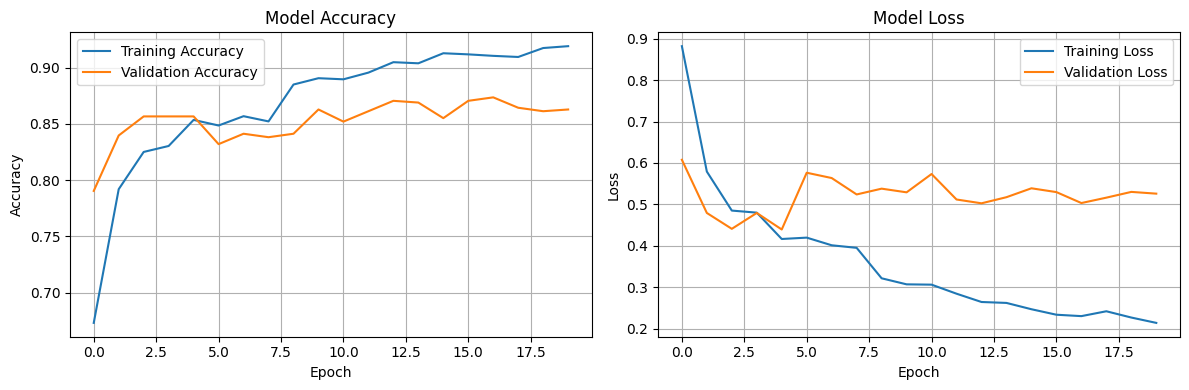

Plot akurasi dan loss disimpan sebagai /content/accuracy_loss_plot.png

Analisis Plot:
Model memiliki performa seimbang antara training dan validation.


In [9]:
# Evaluasi
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\nAkurasi pada data training: {train_accuracy*100:.2f}%")
print(f"Akurasi pada data validation: {val_accuracy*100:.2f}%")
print(f"Akurasi pada data test: {test_accuracy*100:.2f}%")
print(f"Loss pada data training: {train_loss:.4f}")
print(f"Loss pada data validation: {val_loss:.4f}")
print(f"Loss pada data test: {test_loss:.4f}")

# Verifikasi
if train_accuracy < 0.85 or test_accuracy < 0.85:
    print("Peringatan: Akurasi training atau test di bawah 85%! Pertimbangkan tuning model.")

# Plot
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/accuracy_loss_plot.png')
plt.show()
print("Plot akurasi dan loss disimpan sebagai /content/accuracy_loss_plot.png")

# Analisis
print("\nAnalisis Plot:")
if history.history['val_accuracy'][-1] > history.history['accuracy'][-1]:
    print("Model cenderung underfitting (validation accuracy > training accuracy).")
elif history.history['accuracy'][-1] > history.history['val_accuracy'][-1] + 0.1:
    print("Model cenderung overfitting (training accuracy jauh > validation accuracy).")
else:
    print("Model memiliki performa seimbang antara training dan validation.")


## Konversi Model

In [10]:
# Muat model
model = tf.keras.models.load_model('/content/model.keras')

# SavedModel
saved_model_path = '/content/saved_model'
model.export(saved_model_path)
print(f"Model disimpan sebagai SavedModel di {saved_model_path}")

# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = '/content/tflite/model.tflite'
os.makedirs(os.path.dirname(tflite_path), exist_ok=True)
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model disimpan sebagai TensorFlow Lite di {tflite_path}")

# TFJS
tfjs_path = '/content/tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_path, weight_shard_size_bytes=60*1024*1024)
print(f"Model disimpan sebagai TensorFlow.js di {tfjs_path}")

# Verifikasi TFJS
tfjs_files = os.listdir(tfjs_path)
bin_files = [f for f in tfjs_files if f.endswith('.bin')]
print(f"File TFJS: {tfjs_files}")
print(f"Jumlah shard (.bin): {len(bin_files)}")

# Label.txt
labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
label_path = '/content/tflite/label.txt'
with open(label_path, 'w') as f:
    for label in labels:
        f.write(f'{label}\n')
print(f"Label disimpan: {label_path}")
with open(label_path, 'r') as f:
    print("Isi label.txt:")
    print(f.read())

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138468002738064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002736720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002737104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002736912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002738256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002735568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002735952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002733648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002733456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002736144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138468002

Model disimpan sebagai TensorFlow Lite di /content/tflite/model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
Model disimpan sebagai TensorFlow.js di /content/tfjs_model
File TFJS: ['group1-shard1of1.bin', 'model.json']
Jumlah shard (.bin): 1
Label disimpan: /content/tflite/label.txt
Isi label.txt:
daisy
dandelion
rose
sunflower
tulip



## Inference (Optional)


Hasil Inference:
Gambar 1: 14674743211_f68b13f6d9.jpg
Prediksi: daisy, True: daisy, Confidence: 1.00

Gambar 2: 34679936936_9924d79c8d_n.jpg
Prediksi: sunflower, True: dandelion, Confidence: 0.84

Gambar 3: 3873271620_1d9d314f01_n.jpg
Prediksi: rose, True: rose, Confidence: 0.67

Gambar 4: 5018120483_cc0421b176_m.jpg
Prediksi: sunflower, True: sunflower, Confidence: 1.00

Gambar 5: 6038098425_b3b4fb62cc_m.jpg
Prediksi: tulip, True: tulip, Confidence: 0.59



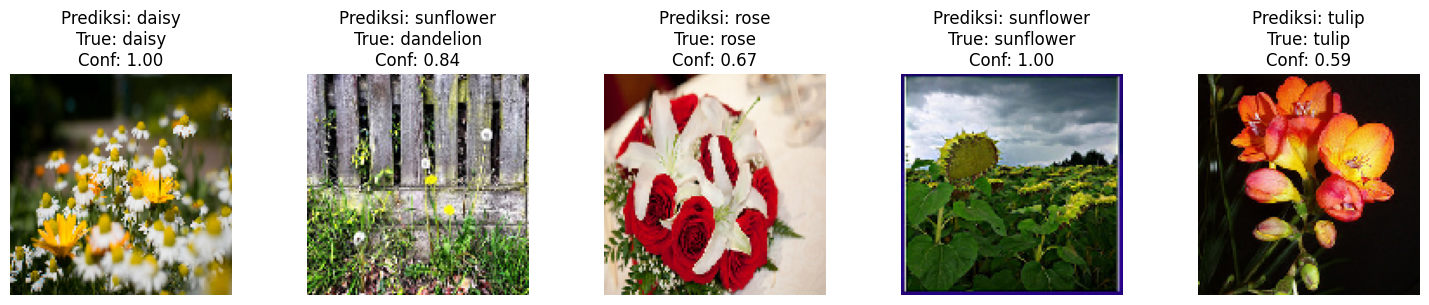

Inference selesai!


In [11]:
# Muat model TFLite
interpreter = tf.lite.Interpreter(model_path='/content/tflite/model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk memproses gambar
def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array

# Pilih 5 gambar acak dari test set
test_images = []
for cls in classes:
    cls_dir = os.path.join(test_dir, cls)
    images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        test_images.append(random.choice(images))

# Inference
print("\nHasil Inference:")
plt.figure(figsize=(15, 3))
for i, image_path in enumerate(test_images, 1):
    # Proses gambar
    img_array = preprocess_image(image_path)

    # Prediksi
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data[0])
    confidence = output_data[0][predicted_class]

    # Nama kelas
    predicted_label = labels[predicted_class]
    true_label = os.path.basename(os.path.dirname(image_path))

    # Tampilkan
    plt.subplot(1, 5, i)
    img = load_img(image_path, target_size=(128, 128))
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_label}\nTrue: {true_label}\nConf: {confidence:.2f}")
    plt.axis('off')

    print(f"Gambar {i}: {os.path.basename(image_path)}")
    print(f"Prediksi: {predicted_label}, True: {true_label}, Confidence: {confidence:.2f}\n")

plt.tight_layout()
plt.show()
print("Inference selesai!")